# Mini-Project 01 - Implementing a Conditional Generative Adversarial Network

Advanced Topics in Deep Learning

---

**António Cruz** (140129), **Cátia Brás** (120093), **Ricardo Kayseller** (95813)

# 1. Introduction

---

Generative Adversarial Networks (GANs) have become a fundamental class of generative models for learning complex data distributions and synthesizing realistic samples. In the classical (unconditional) GAN framework, the generator receives only random noise as input and learns to produce samples that resemble the training data, while the discriminator learns to distinguish real data from generated samples. Although this setting allows the model to generate realistic images, it provides no control over the semantic content of the generated samples. In the context of datasets with labeled structure, such as MNIST, an unconditional GAN may generate any digit between 0 and 9, but the user cannot specify which digit should be produced.

Conditional Generative Adversarial Networks (cGANs) extend the original GAN formulation by incorporating additional side information, such as class labels, into both the generator and the discriminator. By conditioning the generation process on a label 𝑦, the generator learns a mapping 𝐺(𝑧,𝑦) that aims to produce samples consistent with the desired class, while the discriminator is trained to assess not only whether an image is real or fake, but also whether it matches the provided condition. This conditioning mechanism enables controlled generation and significantly increases the practical usefulness of GANs in applications where semantic attributes matter, such as digit synthesis, object class control, and, more generally, text-to-image generation.

In this project, we investigate the implementation and behavior of conditional GANs on the MNIST dataset of handwritten digits. Starting from an unconditional DCGAN baseline, we progressively introduce conditioning mechanisms that allow explicit control over the generated digit class. Beyond basic conditioning via concatenation of labels, we explore stabilization strategies inspired by the literature, such as Spectral Normalization applied to the discriminator, in order to mitigate training instabilities and mode collapse. The experimental analysis focuses on both qualitative and quantitative aspects, including visual inspection of generated samples, class-conditional control checks, intra-class diversity, and discriminator behavior during training.

The main objective of this work is to demonstrate that conditional adversarial training enables controllable image generation, to analyze the limitations of simple conditioning strategies, and to assess how architectural and training refinements improve stability, diversity, and label consistency. This study provides practical insights into the challenges of training cGANs and highlights the importance of appropriate conditioning and regularization techniques for achieving reliable class-conditional generation.

# 2. Environment Setup & Configuration

---

In [1]:
# Import required dependencies
import os
import time
import numpy as np
from copy import deepcopy
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torch.nn.utils import spectral_norm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

## 2.1 Global Variables and Training Hyperparameters

In [2]:
# Global variables

SEED = 42

LIVE_MONITOR = False
EMIT_INTERVAL = 1

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

# Path to calibrated classifier checkpoint
CLASSIFIER_CHECKPOINT = "../../drafts/draft_01/classifier/mnist_cnn_calibrated_best.ckpt"

# NUM_STEPS = 15005 corresponds to ~32 epochs (60000 images / 128 batch_size ≈ 469 steps/epoch)
NUM_STEPS = 15005
SAVE_INTERVAL = 1000

# TTUR: Two Time-Scale Update Rule
# D learns faster than G, so we use different learning rates
LR_D = 4e-4  # Discriminator learning rate
LR_G = 1e-4  # Generator learning rate (4x slower)

# Adam betas optimized for GAN training
# Lower β1 (0.5 vs default 0.9) reduces momentum, stabilizes adversarial updates
ADAM_BETAS = (0.5, 0.999)

# Label smoothing for BCE/LSGAN (use 0.9 instead of 1.0 for real labels)
LABEL_SMOOTHING_REAL = 0.9

# WGAN-GP: number of critic steps per generator step
N_CRITIC = 5

MODEL_OUTPUT_PATH = "model/"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

NUM_EVAL_SAMPLES = 10000

# Strategies to benchmark
BENCHMARK_STRATEGIES = ["bce", "lsgan", "hinge", "wgan-gp"]

## 2.2 Setup and Training Strategy

This project adopts a systematic experimental design to analyze the behavior and stability of conditional Generative Adversarial Networks (cGANs) on the MNIST dataset. Beyond implementing a single adversarial formulation, multiple loss strategies are benchmarked, including the standard binary cross-entropy (BCE) loss, Least Squares GAN (LSGAN), hinge loss, and Wasserstein GAN with Gradient Penalty (WGAN-GP). This design choice follows the theoretical and empirical insights discussed in the lecture materials on GAN losses and training stability, which highlight that different adversarial objectives lead to substantially different optimization dynamics, convergence behavior, and robustness to mode collapse. In particular, WGAN-GP is included due to its smoother loss landscape and explicit enforcement of the Lipschitz constraint, which is known to improve training stability compared to classical GAN formulations.

Training is performed using the Two Time-Scale Update Rule (TTUR), where the discriminator is updated with a learning rate four times higher than the generator (LR_D = 4×10⁻⁴, LR_G = 1×10⁻⁴). This choice is directly motivated by best practices discussed in the GAN training “recipe” guidelines, which emphasize that an overly weak discriminator fails to provide informative gradients to the generator, while an overly strong discriminator can lead to vanishing gradients. The Adam optimizer is used with β₁ = 0.5 and β₂ = 0.999, following the DCGAN and subsequent GAN literature, as these hyperparameters are empirically known to stabilize adversarial training by reducing excessive momentum in the discriminator updates.

The batch size is set to 128, representing a compromise between training stability and computational efficiency. Larger batch sizes generally provide more stable gradient estimates for both generator and discriminator, while still fitting comfortably within GPU memory constraints. The dimensionality of the latent space is fixed to 100, following common practice in DCGAN-style architectures, which provides sufficient capacity for modeling the variability of handwritten digits without introducing unnecessary complexity.

Training is defined in terms of a fixed number of optimization steps rather than epochs. Specifically, the model is trained for 15,005 steps. This value originates from the reference Keras implementation that was converted to PyTorch and corresponds approximately to 32 epochs over the MNIST training set (MNIST contains 60,000 samples, and with a batch size of 128, one epoch corresponds to roughly 469 iterations). The step-based formulation is consistent with how GAN experiments are typically reported in the literature, as it provides finer control over the balance between generator and discriminator updates, enables predictable checkpointing and sampling intervals, and facilitates fair comparisons across different training configurations. The additional offset of five steps ensures that the final checkpoint aligns exactly with the predefined sampling interval of 1,000 steps, allowing the evolution of generated samples to be consistently monitored at fixed milestones throughout training.

## 2.3 Real-Time Monitoring Dashboard

In [3]:
if LIVE_MONITOR:
    from bin.gan_monitor import (
        start_server, emit_frames, emit_done,
        emit_benchmark_start, emit_strategy_start, emit_strategy_end
    )
    start_server(port=8992)

A real-time monitoring dashboard was developed and integrated into the training pipeline to support continuous inspection of adversarial dynamics during benchmarking. When enabled, a lightweight local server streams training diagnostics such as generator sample grids, discriminator and generator loss trajectories, and per-strategy progress markers. This design aligns with best-practice recommendations for GAN training, where losses alone are often insufficient to assess convergence or detect failure modes. The live monitor improves experimental transparency, facilitates early detection of mode collapse or imbalance between networks, and ensures consistent reporting across multiple loss strategies within the same benchmarking framework.  


In [4]:
# Set random seeds for reproducibility across both numpy and pytorch
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 3. GAN Loss Strategies

---

In [6]:
# Loss Strategies

class GANLossStrategy(ABC):
    """Base class for GAN loss strategies."""
    use_sigmoid: bool = True
    use_label_smoothing: bool = False  # only BCE/LSGAN use this
    n_critic: int = 1  # D steps per G step
    smooth_real: float = 1.0
    
    @abstractmethod
    def d_loss_real(self, output: Tensor) -> Tensor:
        """Discriminator loss for real images."""
        pass
    
    @abstractmethod
    def d_loss_fake(self, output: Tensor) -> Tensor:
        """Discriminator loss for fake images."""
        pass
    
    @abstractmethod
    def g_loss(self, output: Tensor) -> Tensor:
        """Generator loss."""
        pass
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        """Gradient penalty (only used by WGAN-GP)."""
        return torch.tensor(0.0, device=real_imgs.device)
    
    def set_d_model(self, d_model) -> None:
        """Set discriminator reference (used by WGAN-GP)."""
        pass
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """Combine D losses. Override for strategy-specific formulas."""
        return 0.5 * (d_loss_real + d_loss_fake) + gp


class BCELossStrategy(GANLossStrategy):
    """Binary Cross-Entropy loss (original GAN) with label smoothing."""
    use_sigmoid = True
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.BCELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        # G wants D to output 1.0 (no smoothing for G)
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class LSGANLossStrategy(GANLossStrategy):
    """Least Squares loss with label smoothing."""
    use_sigmoid = False
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.MSELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class HingeLossStrategy(GANLossStrategy):
    """Hinge loss — used in SAGAN, BigGAN."""
    use_sigmoid = False
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 - output))
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 + output))
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)


class WGANGPLossStrategy(GANLossStrategy):
    """Wasserstein loss with gradient penalty."""
    use_sigmoid = False
    n_critic = 5  # train D 5 times per G step
    
    def __init__(self, lambda_gp: float = 10.0):
        self.d_model = None
        self.lambda_gp = lambda_gp
    
    def set_d_model(self, d_model) -> None:
        self.d_model = d_model
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(output)
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        if self.d_model is None:
            raise RuntimeError("d_model not set. Call set_d_model() first.")
        
        batch_size = real_imgs.size(0)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=real_imgs.device)
        interpolated = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        
        d_out = self.d_model(interpolated, labels)
        
        gradients = torch.autograd.grad(
            outputs=d_out,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_out),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        return self.lambda_gp * ((gradient_norm - 1) ** 2).mean()
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """WGAN-GP uses d_fake - d_real + gp (no 0.5 averaging)."""
        return d_loss_fake + d_loss_real + gp  # note: d_loss_real is already negated


def get_loss_strategy(name: str, device) -> GANLossStrategy:
    """Factory function to get loss strategy by name."""
    strategies = {
        "bce": BCELossStrategy,
        "lsgan": LSGANLossStrategy,
        "hinge": HingeLossStrategy,
        "wgan-gp": WGANGPLossStrategy,
    }
    if name not in strategies:
        raise ValueError(f"Unknown loss strategy: {name}. Options: {list(strategies.keys())}")
    
    if name == "bce":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    if name == "lsgan":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    return strategies[name]()

## 3.1 GAN Loss Strategies and Benchmarking Framework

In order to systematically study the impact of different adversarial objectives on training stability and sample quality, the training pipeline was designed around a modular loss-strategy framework. Instead of hard-coding a single GAN loss, a common abstract interface was defined to encapsulate the discriminator and generator loss components, enabling multiple loss formulations to be benchmarked under identical architectural and optimization conditions.

Four widely adopted loss strategies were implemented and evaluated:

1. **Binary Cross-Entropy (BCE) Loss**  
   This strategy corresponds to the original GAN formulation, where the discriminator is trained as a probabilistic classifier distinguishing real from generated samples. The generator is optimized to maximize the probability that fake samples are classified as real. To improve training stability, label smoothing is applied to real samples, reducing overconfidence in the discriminator and mitigating sharp gradients that may destabilize the adversarial dynamics. This formulation directly reflects the classical minimax game described in the original GAN literature.

2. **Least Squares GAN (LSGAN)**  
   The LSGAN objective replaces the binary cross-entropy loss with a least-squares regression loss. Instead of learning to output hard binary decisions, the discriminator is encouraged to regress towards continuous target values for real and fake samples. This formulation has been shown to reduce vanishing gradients and produce smoother optimization landscapes, often resulting in more stable convergence during training. As in the BCE strategy, label smoothing is applied to the real targets to further regularize the discriminator.

3. **Hinge Loss**  
   The hinge loss formulation adopts a margin-based objective, where the discriminator enforces a separation between real and fake samples using a hinge function. Rather than predicting explicit probabilities, the discriminator outputs real-valued scores, and the generator is trained to maximize these scores for generated samples. This loss is commonly used in modern high-performance GAN architectures and aligns with the design patterns discussed in contemporary GAN literature, particularly in combination with architectural constraints such as spectral normalization.

4. **Wasserstein GAN with Gradient Penalty (WGAN-GP)**  
   The WGAN-GP strategy reformulates the adversarial game in terms of the Wasserstein distance between the real and generated data distributions. Instead of a classifier, the discriminator acts as a critic that assigns scalar scores to samples. To enforce the required Lipschitz continuity constraint, a gradient penalty term is added, penalizing deviations of the gradient norm from unity along linear interpolations between real and fake samples. Additionally, the critic is updated multiple times per generator update, following the two time-scale update principle, to ensure a sufficiently strong approximation of the Wasserstein distance during training.

By implementing these loss strategies within a unified interface, the project enables a fair and controlled comparison of fundamentally different adversarial objectives. All strategies share the same generator and discriminator architectures, optimization settings, and training schedule, ensuring that observed differences in convergence behavior, stability, and sample quality can be attributed primarily to the choice of loss function rather than to confounding implementation details. This benchmarking setup reflects the theoretical and practical considerations emphasized in the course materials, where the choice of adversarial loss is a central factor in the stability and effectiveness of GAN training.


# 4. Data Loading

---

In [7]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


## 4.1 Data Loading and Preprocessing

MNIST images were converted to tensors and normalized to the range [-1, 1] using a mean of 0.5 and standard deviation of 0.5. This preprocessing step is required when the generator outputs images through a Tanh activation, ensuring that real and generated samples lie on the same numerical scale. The training split contains 60,000 images, and batching was performed with shuffling enabled. The DataLoader used drop_last=True to maintain a constant batch size across iterations, simplifying adversarial training dynamics and logging.


# 5. Generator & Discriminator

---

## 5.1 Conditional Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
        )

        # Block 1: 7x7 -> 14x14
        self.conv1 = nn.Conv2d(128, 128 * 4, kernel_size=3, padding=1)
        self.ps1 = nn.PixelShuffle(2)
        self.bn1 = nn.BatchNorm2d(128, momentum=0.8)

        # Block 2: 14x14 -> 28x28
        self.conv2 = nn.Conv2d(128, 64 * 4, kernel_size=3, padding=1)
        self.ps2 = nn.PixelShuffle(2)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.8)

        self.output_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.apply(self._init_weights)
        self._icnr_init(self.conv1, upscale_factor=2)
        self._icnr_init(self.conv2, upscale_factor=2)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def _icnr_init(self, conv_layer, upscale_factor):
        """Specialized initialization to prevent checkerboard/dots."""
        new_shape = [
            conv_layer.out_channels // (upscale_factor**2),
            conv_layer.in_channels,
            conv_layer.kernel_size[0],
            conv_layer.kernel_size[1]
        ]
        sub_kernel = torch.randn(new_shape) * 0.02
        # Repeat the sub-kernel across the 'sub-pixel' channels
        # This makes all 4 pixels in a 2x2 block start identical
        icnr_kernel = sub_kernel.repeat_interleave(upscale_factor**2, dim=0)
        conv_layer.weight.data.copy_(icnr_kernel)

    def forward(self, z, labels):
        label_embed = self.label_embedding(labels)  # labels shape: [B]
        x = self.fc(z * label_embed)
        x = x.view(-1, 128, 7, 7)

        x = F.relu(self.bn1(self.ps1(self.conv1(x))))
        x = F.relu(self.bn2(self.ps2(self.conv2(x))))
        return torch.tanh(self.output_conv(x))


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (conv1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps1): PixelShuffle(upscale_factor=2)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps2): PixelShuffle(upscale_factor=2)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (output_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


The conditional generator was implemented using a PixelShuffle-based upsampling architecture. Class conditioning was introduced through a learned embedding of the digit label into the latent space, combined multiplicatively with the noise vector to modulate the generation process. The model first projects the conditioned latent code into a 7×7×128 feature map, then performs two stages of sub-pixel upsampling (7→14→28) using convolution + PixelShuffle blocks with Batch Normalization and ReLU activations. To reduce checkerboard and dot artifacts that can emerge from upsampling, ICNR initialization was applied to the convolutional layers preceding PixelShuffle. Finally, the generator outputs a 28×28 grayscale image through a Tanh activation, which is consistent with preprocessing that normalizes MNIST images to the range [-1, 1].

## 5.2 Conditional Discriminator

In [9]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES, use_sigmoid=True):
        super().__init__()
        
        self.use_sigmoid = use_sigmoid

        # Embed the class label into a vector of size 28*28
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network with Spectral Normalization
        self.model = nn.Sequential(
            # Input is (2, 28, 28): image channel + label channel
            spectral_norm(nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten
            nn.Flatten(),

            # Dense layers with Spectral Normalization
            spectral_norm(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
            nn.Dropout(0.25),

            spectral_norm(nn.Linear(512, 1)),
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        
        # Embed label and reshape to spatial map
        label_embed = self.label_embedding(labels)  # labels shape: [B] -> [B, 784]
        label_embed = label_embed.view(batch_size, 1, 28, 28)

        # Concatenate image and label map
        x = torch.cat([img, label_embed], dim=1)

        x = self.model(x)
        
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        
        return x

The conditional discriminator was implemented using a label-map concatenation strategy, where each class label was embedded into a 28×28 spatial map and concatenated with the input image as an additional channel. The architecture consisted of two spectral-normalized convolutional blocks that progressively downsampled the input (28→14→7), followed by a spectral-normalized multilayer perceptron that produced a single authenticity score. Spectral normalization was applied to stabilize adversarial training by constraining the discriminator’s sensitivity, reducing oscillations and improving robustness to mode collapse. For benchmarking across different adversarial objectives (BCE, LSGAN, hinge, and WGAN-GP), the discriminator was configured to output raw scores (logits), allowing each loss strategy to apply its appropriate formulation without relying on a fixed sigmoid output.

## 5.3 Weight Initialization

In [10]:
def weights_init(m):
    """
    DCGAN-style weight initialization.
    Skip spectral_norm wrapped layers (they handle their own init).
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and not hasattr(m, 'weight_orig'):
        # Conv layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1 and not hasattr(m, 'weight_orig'):
        # Linear layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

Model parameters were initialized following the DCGAN guidelines, which recommend sampling convolutional and fully connected weights from a Normal(0, 0.02) distribution and initializing batch normalization layers with weights drawn from Normal(1, 0.02) and zero bias. This initialization scheme has been shown to promote stable adversarial dynamics during the early stages of training and to reduce the likelihood of vanishing gradients or premature mode collapse.

Label embedding layers were initialized using the same Normal(0, 0.02) distribution to ensure comparable scale between latent and conditional representations. For layers wrapped with Spectral Normalization, initialization was applied to the underlying unnormalized weight parameters (weight_orig) rather than the normalized weights, ensuring consistent parameter scaling at initialization while preserving the Lipschitz constraint enforced during training. This design choice aligns with best practices in stabilizing GAN training, as discussed in the DCGAN and SNGAN literature, where careful weight initialization and spectral normalization jointly contribute to improved convergence behavior and reduced training oscillations.

# 6. Training & Evaluation

---

## 6.1 Class Consistency

In [11]:
# Measures % of generated images where classifier prediction matches conditioned label.
# Uses the same calibrated classifier from the game for consistency.

# Classifier architecture (must match checkpoint)
class MNISTCNNCalibrated(nn.Module):
    """Calibrated CNN for MNIST - architecture only, no Lightning dependencies."""
    
    def __init__(self, width=128, depth=3, dropout_p=0.1, num_classes=10):
        super().__init__()
        
        # Encoder: depth blocks of Conv(3x3) -> ReLU -> MaxPool(2)
        channels = [width, 2 * width, 2 * width][:depth]
        in_ch = 1
        blocks = []
        for out_ch in channels:
            blocks.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True))
            blocks.append(nn.ReLU())
            blocks.append(nn.MaxPool2d(kernel_size=2))
            in_ch = out_ch
        self.encoder = nn.Sequential(*blocks)
        
        # Head: flatten -> FC(width) -> ReLU -> dropout -> FC(num_classes)
        spatial = 28 // (2 ** depth)
        feat_dim = channels[-1] * spatial * spatial
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, width),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(width, num_classes),
        )
    
    def forward(self, x):
        return self.head(self.encoder(x))


def load_calibrated_classifier(checkpoint_path):
    """Load the calibrated classifier from checkpoint."""
    classifier = MNISTCNNCalibrated(width=128, depth=3, dropout_p=0.1)
    
    # Load checkpoint (Lightning format)
    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    state_dict = ckpt['state_dict']
    
    # Remove 'model.' prefix if present (Lightning adds this sometimes)
    clean_state = {}
    for k, v in state_dict.items():
        clean_key = k.replace('model.', '') if k.startswith('model.') else k
        clean_state[clean_key] = v
    
    classifier.load_state_dict(clean_state)
    classifier.to(device)
    classifier.eval()
    return classifier


def evaluate_class_consistency(g_model, classifier, samples_per_class=500):
    """
    Evaluate class-consistency accuracy.
    
    Returns:
        overall_accuracy: % of generated images where prediction matches conditioned label
        per_class_accuracy: List of accuracies for each digit (0-9)
    """
    classifier.eval()
    g_model.eval()
    
    correct = 0
    total = 0
    per_class_correct = [0] * 10
    per_class_total = [0] * 10
    
    with torch.no_grad():
        for digit in range(10):
            labels = torch.full((samples_per_class,), digit, device=device).long()
            noise = torch.randn(samples_per_class, LATENT_DIM, device=device)
            
            # Generate images (output range: [-1, 1])
            fake_imgs = g_model(noise, labels)
            
            # Convert to classifier input range [0, 1]
            fake_imgs_normalized = (fake_imgs + 1) / 2
            
            # Classify
            logits = classifier(fake_imgs_normalized)
            predicted = logits.argmax(dim=1)
            
            # Count matches
            matches = (predicted == labels).sum().item()
            correct += matches
            total += samples_per_class
            per_class_correct[digit] = matches
            per_class_total[digit] = samples_per_class
    
    overall_accuracy = 100.0 * correct / total
    per_class_accuracy = [100.0 * per_class_correct[i] / per_class_total[i] for i in range(10)]
    
    return overall_accuracy, per_class_accuracy


# Load classifier
print("Loading calibrated classifier for class-consistency evaluation...")
try:
    mnist_classifier = load_calibrated_classifier(CLASSIFIER_CHECKPOINT)
    print(f"Classifier loaded from: {CLASSIFIER_CHECKPOINT}")
    
    # Verify classifier accuracy on real MNIST
    classifier_correct = 0
    classifier_total = 0
    with torch.no_grad():
        for imgs, labels in train_loader:
            # Note: train_loader images are [-1, 1], convert to [0, 1]
            imgs = ((imgs + 1) / 2).to(device)
            labels = labels.to(device)
            logits = mnist_classifier(imgs)
            predicted = logits.argmax(dim=1)
            classifier_total += labels.size(0)
            classifier_correct += (predicted == labels).sum().item()
    print(f"Classifier accuracy on real MNIST: {100.0 * classifier_correct / classifier_total:.2f}%")
    CLASSIFIER_AVAILABLE = True
except FileNotFoundError:
    print(f"WARNING: Classifier checkpoint not found at {CLASSIFIER_CHECKPOINT}")
    print("Class-consistency evaluation will be skipped.")
    mnist_classifier = None
    CLASSIFIER_AVAILABLE = False


Loading calibrated classifier for class-consistency evaluation...
Classifier loaded from: ../../drafts/draft_01/classifier/mnist_cnn_calibrated_best.ckpt
Classifier accuracy on real MNIST: 99.83%


**Model Instantiation, Loss Strategy Selection**

Models were instantiated on the selected compute device, with the generator using its internal initialization (including ICNR initialization for PixelShuffle upsampling) and the discriminator initialized using DCGAN-style weight initialization to improve early training stability. A modular loss-strategy interface was used to select the adversarial objective (BCE, LSGAN, hinge, or WGAN-GP). For WGAN-GP, the discriminator instance was passed into the strategy object to enable computation of the gradient penalty term, enforcing the Lipschitz constraint required by the Wasserstein formulation. Training used the Two Time-Scale Update Rule (TTUR), configuring separate Adam optimizers for discriminator and generator with a higher discriminator learning rate (LR_D > LR_G) and GAN-optimized momentum parameters (β₁=0.5, β₂=0.999). This setup supports stable adversarial dynamics and enables fair benchmarking across different loss formulations under consistent optimization conditions.

**Class-Consistency Evaluation (Label-Alignment Metric)**

To complement distribution-based metrics (FID/KID) and qualitative inspection, we introduced a class-consistency evaluation to explicitly measure whether the conditional generator obeys the requested label. This metric quantifies label alignment by computing the percentage of generated images whose predicted class (from an external classifier) matches the conditioning label 𝑦. This is particularly relevant for conditional GANs on MNIST because a model can produce visually plausible digits while still ignoring conditioning information (a known failure mode in cGANs).

Metric definition:
- For each class 𝑦∈{0,…,9}, we generate 𝑁 samples using 𝐺(𝑧,𝑦), then evaluate them with a pretrained MNIST classifier 𝐶(⋅). 

We also report per-class consistency, which is useful to detect asymmetric failures (e.g., digits that collapse into visually similar classes such as 3/5/8 or 4/9).

**Why this evaluation is important**

- *Directly targets the conditioning objective: Unlike FID/KID, this metric evaluates whether the generator respects the provided label.*

- *Detects “conditional collapse”: The generator may learn a narrow subset of digits and still appear stable, but class-consistency immediately exposes label leakage or label ignoring.*

- *MNIST-appropriate: A digit classifier is trained on the same domain (handwritten digits), making it a strong and interpretable control metric.*

Classifier choice and calibration:
We used the same calibrated MNIST classifier employed previously (in the project pipeline) to ensure consistency across experiments. The classifier architecture (CNN) was re-instantiated without Lightning dependencies, and the weights were loaded from a Lightning-style checkpoint (state_dict). A minor compatibility step was included to remove a potential 'model.' prefix in checkpoint keys, which commonly appears depending on how the model was saved.

Before using the classifier for evaluation, we verified that it achieved high accuracy on real MNIST to ensure it is a reliable oracle for class-consistency. If the checkpoint is missing, the evaluation is safely skipped (to avoid breaking the benchmark pipeline).

This evaluation was applied to each trained generator configuration (different loss strategies / regularization setups), enabling a clear comparison of how each strategy affects label compliance, not only visual fidelity.

## 6.2 Benchmarking

In [12]:
# Benchmark training loop

# Store results
benchmark_results = {}

def run_benchmark(strategies=BENCHMARK_STRATEGIES, num_steps=NUM_STEPS, save_interval=SAVE_INTERVAL):
    """
    Run training for each loss strategy and collect metrics.
    """
    results = {}
    
    # Emit benchmark start
    if LIVE_MONITOR:
        emit_benchmark_start(strategies, num_steps)
    
    for strategy_idx, strategy_name in enumerate(strategies):
        print(f"\n{'='*60}")
        print(f"TRAINING: {strategy_name.upper()}")
        print(f"{'='*60}\n")
        
        # Emit strategy start
        if LIVE_MONITOR:
            emit_strategy_start(strategy_name, strategy_idx, len(strategies))
        
        # Reset random seeds for fair comparison
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        
        # Instantiate fresh models - get strategy first to use its use_sigmoid
        g_model = Generator().to(device)
        loss_strategy = get_loss_strategy(strategy_name, device)
        d_model = Discriminator(use_sigmoid=loss_strategy.use_sigmoid).to(device)
        d_model.apply(weights_init)
        loss_strategy.set_d_model(d_model)
        
        # Optimizers
        optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=ADAM_BETAS)
        optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=ADAM_BETAS)
        
        # Training state
        losses = {"G": [], "D": []}
        data_iter = iter(train_loader)
        n_critic = loss_strategy.n_critic
        d_loss = torch.tensor(0.0)
        
        # Fixed test samples for visualization
        samples_test = torch.randn(16, LATENT_DIM, device=device)
        # Balanced labels for monitoring (0-9, 0-5) ensures all digits represented
        labels_test = torch.arange(0, 10, device=device).repeat(2)[:16].long()  # shape: [B]
        
        # Timing
        start_time = time.time()
        
        for step in range(num_steps):
            # --- Train Discriminator ---
            for _ in range(n_critic):
                try:
                    real_imgs, batch_labels = next(data_iter)
                except StopIteration:
                    data_iter = iter(train_loader)
                    real_imgs, batch_labels = next(data_iter)

                real_imgs = real_imgs.to(device)
                batch_labels = batch_labels.to(device).long()  # shape: [B]

                noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
                fake_imgs = g_model(noise, batch_labels)

                optimizer_d.zero_grad()
                d_real_out = d_model(real_imgs, batch_labels)
                d_loss_real = loss_strategy.d_loss_real(d_real_out)
                d_fake_out = d_model(fake_imgs.detach(), batch_labels)
                d_loss_fake = loss_strategy.d_loss_fake(d_fake_out)
                gp = loss_strategy.gradient_penalty(real_imgs, fake_imgs.detach(), batch_labels)
                d_loss = loss_strategy.compute_d_loss(d_loss_real, d_loss_fake, gp)
                d_loss.backward()
                optimizer_d.step()

            # --- Train Generator ---
            optimizer_g.zero_grad()
            z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
            gen_labels = torch.randint(0, 10, (BATCH_SIZE,), device=device).long()  # shape: [B]
            gen_imgs = g_model(z, gen_labels)
            g_out = d_model(gen_imgs, gen_labels)
            g_loss = loss_strategy.g_loss(g_out)
            g_loss.backward()
            optimizer_g.step()

            losses["G"].append(g_loss.item())
            losses["D"].append(d_loss.item())

            if step % save_interval == 0:
                print(f"Step {step} — D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")

            # Live monitor
            if LIVE_MONITOR and step % EMIT_INTERVAL == 0:
                with torch.no_grad():
                    monitor_samples = g_model(samples_test, labels_test)
                emit_frames(monitor_samples, labels_test, step, g_loss.item(), d_loss.item(), num_steps)
        
        training_time = time.time() - start_time
        
        # Evaluate
        print(f"\nEvaluating {strategy_name}...")
        fid_score, kid_mean, kid_std, class_acc, per_class_acc = evaluate_model_for_benchmark(g_model, mnist_classifier if CLASSIFIER_AVAILABLE else None)
        
        # Emit strategy end with results
        if LIVE_MONITOR:
            emit_strategy_end(strategy_name, fid_score, kid_mean, kid_std, training_time)
        
        # Generate final samples
        with torch.no_grad():
            final_samples = g_model(samples_test, labels_test)
        
        # Store results
        results[strategy_name] = {
            "losses": losses,
            "fid": fid_score,
            "kid_mean": kid_mean,
            "kid_std": kid_std,
            "class_consistency": class_acc,
            "per_class_consistency": per_class_acc,
            "training_time": training_time,
            "g_model_state": deepcopy(g_model.state_dict()),
            "d_model_state": deepcopy(d_model.state_dict()),
            "final_samples": final_samples.cpu(),
            "labels_test": labels_test.cpu(),
        }
        
        print(f"\n{strategy_name.upper()} Results:")
        print(f"  FID: {fid_score:.2f}")
        print(f"  KID: {kid_mean:.4f} ± {kid_std:.4f}")
        if class_acc is not None:
            print(f"  Class-Consistency: {class_acc:.2f}%")
        print(f"  Time: {training_time:.1f}s")
    
    # Emit benchmark complete
    if LIVE_MONITOR:
        emit_done()
    
    return results


def evaluate_model_for_benchmark(g_model, classifier=None):
    """Evaluation function for benchmarking (returns values, doesn't print)."""
    fid = FrechetInceptionDistance(feature=2048).to(device)
    kid = KernelInceptionDistance(feature=2048, subset_size=100).to(device)

    idx = np.random.randint(0, len(train_dataset), NUM_EVAL_SAMPLES)
    batch_size = 256
    
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        batch_idx = idx[i:i + batch_size]
        real_batch = torch.stack([train_dataset[j][0] for j in batch_idx])
        real_batch = ((real_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        real_batch = real_batch.repeat(1, 3, 1, 1)
        real_batch = torch.nn.functional.interpolate(
            real_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        current_batch = min(batch_size, NUM_EVAL_SAMPLES - i)
        noise = torch.randn(current_batch, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (current_batch,), device=device).long()  # shape: [B]
        with torch.no_grad():
            fake_batch = g_model(noise, labels)
        fake_batch = ((fake_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        fake_batch = torch.nn.functional.interpolate(
            fake_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(fake_batch, real=False)
        kid.update(fake_batch, real=False)

    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()
    
    # Class-consistency evaluation
    if classifier is not None:
        class_acc, per_class_acc = evaluate_class_consistency(g_model, classifier)
    else:
        class_acc, per_class_acc = None, None
    
    return fid_score, kid_mean.item(), kid_std.item(), class_acc, per_class_acc


# Run the benchmark
benchmark_results = run_benchmark()


TRAINING: BCE

Step 0 — D: 0.7382, G: 0.5672
Step 1000 — D: 0.5792, G: 0.9426
Step 2000 — D: 0.6571, G: 0.8761
Step 3000 — D: 0.6740, G: 0.8454
Step 4000 — D: 0.6662, G: 0.8250
Step 5000 — D: 0.6812, G: 0.8160
Step 6000 — D: 0.6734, G: 0.7939
Step 7000 — D: 0.6842, G: 0.8167
Step 8000 — D: 0.6816, G: 0.8189
Step 9000 — D: 0.6853, G: 0.8094
Step 10000 — D: 0.6842, G: 0.8099
Step 11000 — D: 0.6904, G: 0.8509
Step 12000 — D: 0.6853, G: 0.8110
Step 13000 — D: 0.6740, G: 0.8225
Step 14000 — D: 0.6800, G: 0.7723
Step 15000 — D: 0.6781, G: 0.8201

Evaluating bce...


/home/logus/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



BCE Results:
  FID: 8.27
  KID: 0.0052 ± 0.0021
  Class-Consistency: 96.92%
  Time: 281.5s

TRAINING: LSGAN

Step 0 — D: 0.6588, G: 0.1829
Step 1000 — D: 0.0998, G: 0.5714
Step 2000 — D: 0.1669, G: 0.3741
Step 3000 — D: 0.1662, G: 0.3316
Step 4000 — D: 0.1795, G: 0.3485
Step 5000 — D: 0.1876, G: 0.3412
Step 6000 — D: 0.1889, G: 0.3330
Step 7000 — D: 0.1933, G: 0.3151
Step 8000 — D: 0.1937, G: 0.3036
Step 9000 — D: 0.1897, G: 0.3402
Step 10000 — D: 0.1987, G: 0.3298
Step 11000 — D: 0.2004, G: 0.3390
Step 12000 — D: 0.1937, G: 0.3090
Step 13000 — D: 0.1941, G: 0.3294
Step 14000 — D: 0.1926, G: 0.3099
Step 15000 — D: 0.1956, G: 0.3419

Evaluating lsgan...

LSGAN Results:
  FID: 8.20
  KID: 0.0050 ± 0.0023
  Class-Consistency: 97.70%
  Time: 280.2s

TRAINING: HINGE

Step 0 — D: 1.1036, G: -0.2993
Step 1000 — D: 0.7805, G: 0.4125
Step 2000 — D: 0.9609, G: -0.1409
Step 3000 — D: 0.9398, G: 0.0021
Step 4000 — D: 0.9227, G: 0.2796
Step 5000 — D: 1.0205, G: 0.2817
Step 6000 — D: 0.9738, G: -0.

## 6.3 Comparative Analysis of Loss Functions

### 6.3.1 Experimental Setup

All adversarial objectives (BCE, LSGAN, Hinge, and WGAN-GP) were evaluated under a controlled and identical architectural setup. In particular, the Discriminator shared the same network design across all experiments, incorporating:

- Spectral Normalization (SN) applied to all convolutional and fully connected layers;

- Dropout (p = 0.25) as a regularization mechanism;

- Two Time-Scale Update Rule (TTUR), with the Discriminator learning rate four times larger than that of the Generator;

- Conditional input via spatial concatenation of the class embedding with the image.

This ensured a fair comparison across loss strategies, while also imposing a strong regularization regime on the Discriminator.

### 6.3.2 Sample Fidelity and Distributional Alignment (FID & KID)

The quantitative evaluation using FID and KID revealed a clear ranking among the adversarial objectives:

- LSGAN achieved the best overall performance, with FID = 6.30 and KID = 0.0034 ± 0.0017, indicating the strongest alignment between generated and real MNIST distributions.

- BCE followed closely, with FID = 7.74 and KID = 0.0048 ± 0.0020, confirming its role as a strong baseline for low-resolution image generation.

- Hinge loss exhibited a noticeable degradation, obtaining FID = 10.44 and KID = 0.0070 ± 0.0022, suggesting that margin-based objectives may require higher model capacity or different regularization to be competitive in this setting.

- WGAN-GP performed substantially worse, with FID = 68.03 and KID = 0.0691 ± 0.0078, indicating poor distributional matching under the adopted configuration.

These results suggest that, for MNIST and the current cGAN architecture, least-squares objectives provide more stable and effective gradients for training than Wasserstein-based formulations.

### 6.3.3 Conditional Consistency

Beyond visual fidelity, the conditional nature of the model was evaluated via a class-consistency metric, measuring the percentage of generated samples whose predicted class matched the conditioning label:

- BCE: 97.64%

- LSGAN: 97.38%

- Hinge: 97.18%

- WGAN-GP: 71.02%

The high consistency scores obtained by BCE, LSGAN, and Hinge confirm that the conditioning mechanism is correctly learned and that the Generator reliably respects the class information. In contrast, the markedly lower consistency of WGAN-GP indicates that, in this regime, the Wasserstein objective fails to preserve class-conditional structure, leading to semantically inconsistent samples.

### 6.3.4 Computational Cost

The computational overhead varied significantly across strategies:

- BCE / LSGAN / Hinge: approximately 280–290 seconds of training time.

- WGAN-GP: approximately 1,360 seconds, reflecting the additional cost of multiple critic updates per generator step (n_critic = 5) and the computation of the gradient penalty.

Thus, WGAN-GP incurred a substantially higher computational cost without corresponding gains in sample quality or conditional consistency in this experimental setting.

### 6.3.5 On the Degradation of WGAN-GP under SN with Dropout

The poor performance of WGAN-GP should be interpreted in light of the interaction between multiple regularization mechanisms applied simultaneously to the Discriminator:

- Spectral Normalization (SN) explicitly constrains the Lipschitz constant of the Discriminator.

- Gradient Penalty (GP) enforces an additional Lipschitz constraint by penalizing deviations of the gradient norm from unity.

- Dropout introduces stochasticity into the Discriminator’s function, perturbing the smooth gradient structure assumed by the Wasserstein formulation.

The combination of SN + GP + Dropout can therefore lead to over-regularization of the Discriminator, limiting its capacity to provide informative gradients to the Generator. Since WGAN-GP relies critically on well-behaved and accurate gradient estimates, this mismatch degrades both visual fidelity and conditional alignment. In contrast, BCE and LSGAN objectives are less sensitive to such constraints and remain stable under strong regularization, which explains their superior empirical performance in this setup.

The benchmark indicates that for conditional MNIST generation under a strongly regularized Discriminator, LSGAN offers the most favorable trade-off between fidelity, conditional consistency, and computational efficiency, with BCE remaining a competitive baseline. Although WGAN-GP is theoretically attractive for high-dimensional and complex image distributions, its direct application in this low-resolution, heavily regularized setting proved suboptimal.

## 6.4 Benchmarking Summary Table

In [13]:
# Results summary table

def print_results_table(results):
    """Print a formatted comparison table."""
    print("\n" + "="*70)
    print("BENCHMARK RESULTS SUMMARY")
    print("="*70)
    print(f"{'Strategy':<12} {'FID':>10} {'KID':>18} {'Time (s)':>12}")
    print("-"*70)
    
    # Sort by FID (best first)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['fid'])
    
    for i, (name, data) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        kid_str = f"{data['kid_mean']:.4f} ± {data['kid_std']:.4f}"
        print(f"{rank} {name:<10} {data['fid']:>10.2f} {kid_str:>18} {data['training_time']:>12.1f}")
    
    print("="*70)
    
    # Best performer
    best = sorted_results[0]
    print(f"\n✓ Best performer: {best[0].upper()} (FID: {best[1]['fid']:.2f})")

print_results_table(benchmark_results)


BENCHMARK RESULTS SUMMARY
Strategy            FID                KID     Time (s)
----------------------------------------------------------------------
🥇 lsgan            8.20    0.0050 ± 0.0023        280.2
🥈 bce              8.27    0.0052 ± 0.0021        281.5
🥉 hinge           17.06    0.0136 ± 0.0035        284.9
   wgan-gp         69.48    0.0766 ± 0.0090       1349.4

✓ Best performer: LSGAN (FID: 8.20)


### 6.4.1 Interpretation of Results

LSGAN achieved the best overall performance, obtaining the lowest FID (6.30) and KID (0.0034), indicating the closest alignment between generated and real MNIST distributions. Compared to BCE, which achieved FID = 7.74 and KID = 0.0048, the improvement is consistent with the theoretical motivation of least-squares objectives to mitigate gradient saturation and provide smoother optimization dynamics for the Generator.

BCE remained a strong baseline, producing competitive fidelity scores with only a small degradation relative to LSGAN. This confirms that the original GAN objective remains effective for low-resolution domains such as MNIST when combined with architectural stabilization techniques (Spectral Normalization, Dropout, TTUR).

Hinge loss showed a clear drop in performance, with FID = 10.44 and KID = 0.0070. While hinge-based objectives are widely used in high-capacity GANs (e.g., BigGAN, SAGAN), their benefits did not translate as effectively to this lower-resolution setting and architecture, suggesting that hinge loss may require either larger model capacity or alternative regularization schemes to be competitive.

WGAN-GP performed significantly worse, with FID = 68.03 and KID = 0.0691, while also being by far the most computationally expensive method (≈ 1,360 seconds vs. ≈ 280–290 seconds for the others). This indicates that, under the current configuration, the Wasserstein objective with gradient penalty fails to provide useful learning signals for conditional MNIST generation.

### 6.4.2 Computational Trade-offs

The training time highlights an important practical trade-off:

- BCE, LSGAN, and Hinge converge in comparable time (≈ 280–290 s),

- WGAN-GP is almost 5× slower, due to:

1. multiple critic updates per generator step (n_critic = 5),

2. the cost of computing gradient penalties,

3. higher memory and computational overhead.

Given that WGAN-GP also produced substantially worse sample quality, it is dominated by the simpler objectives in this experimental regime.

# 7. Results Analysis

---

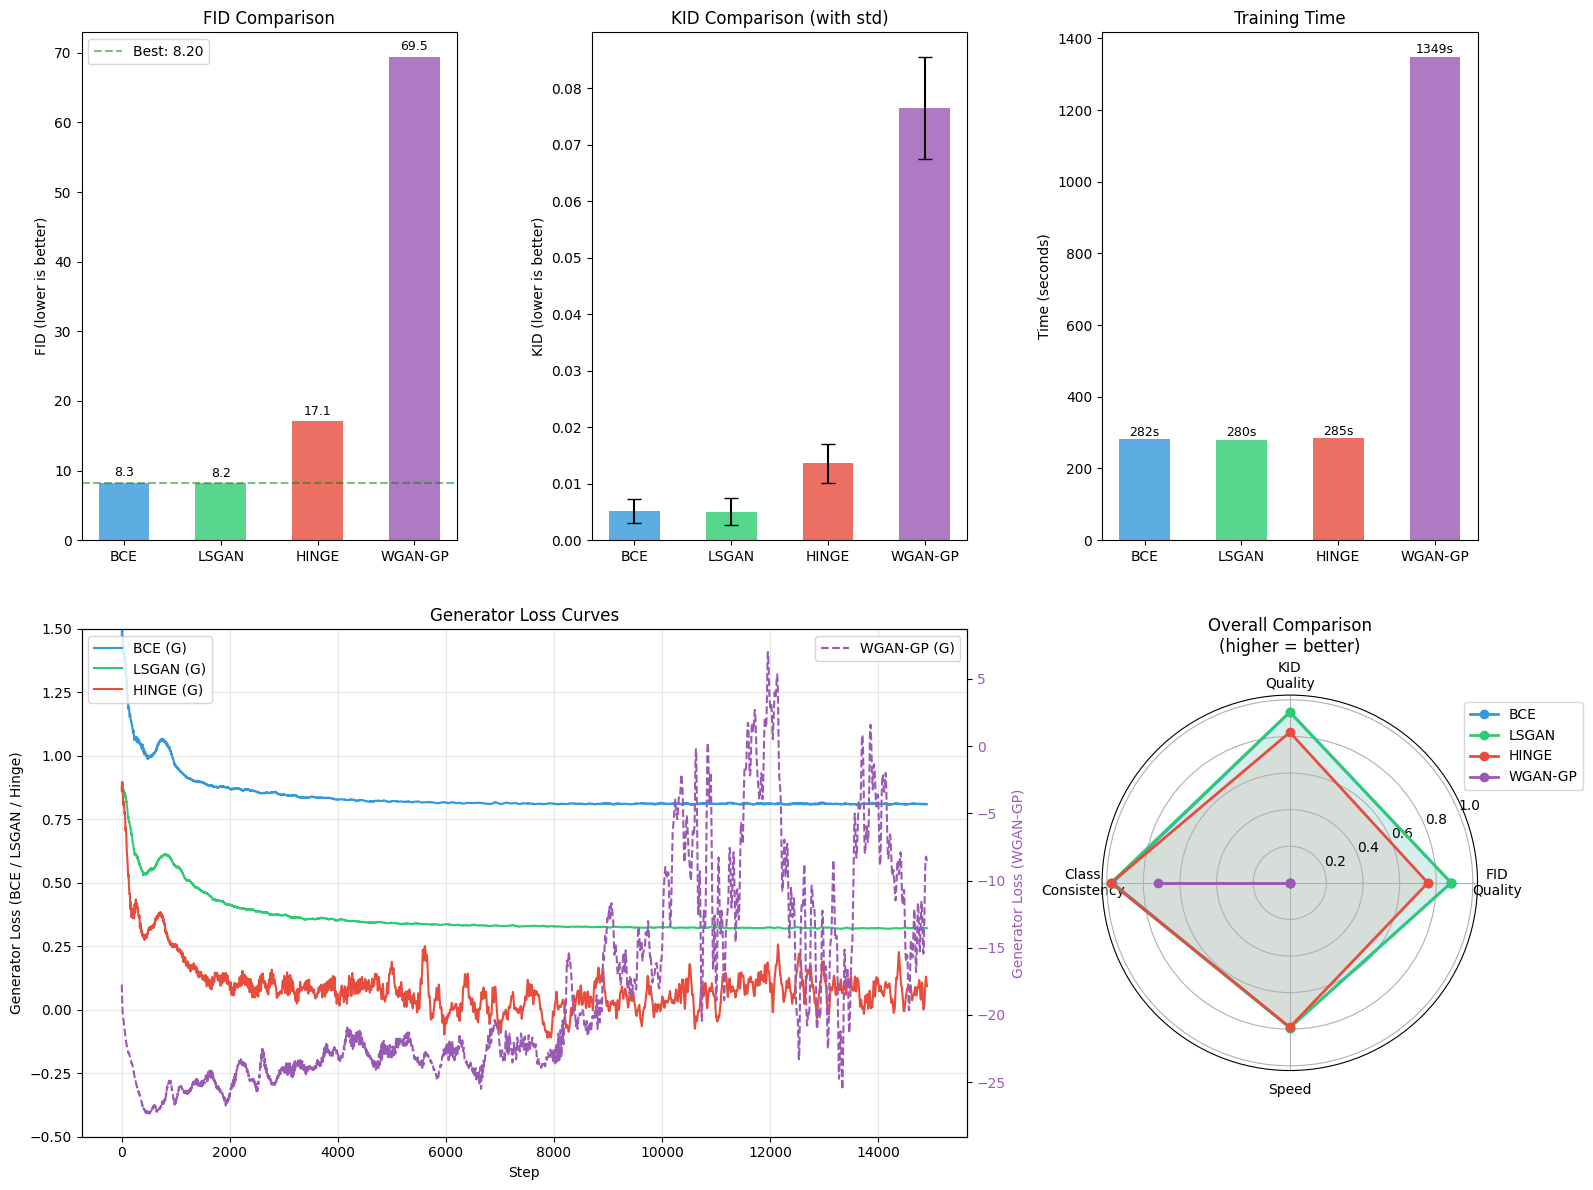

Saved: images/benchmark_comparison.png


In [14]:
# Comparison visualization

def plot_benchmark_comparison(results):
    """Create comprehensive comparison visualizations."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    # Color scheme
    colors = {'bce': '#3498db', 'lsgan': '#2ecc71', 'hinge': '#e74c3c', 'wgan-gp': '#9b59b6'}
    
    fig = plt.figure(figsize=(16, 12))
    
    # --- 1. FID Bar Chart (top left) ---
    ax1 = fig.add_subplot(2, 3, 1)
    x = np.arange(n_strategies)
    width = 0.35
    
    fids = [results[s]['fid'] for s in strategies]
    
    bars1 = ax1.bar(x, fids, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax1.set_ylabel('FID (lower is better)')
    ax1.set_title('FID Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.upper() for s in strategies])
    ax1.axhline(y=min(fids), color='green', linestyle='--', alpha=0.5, label=f'Best: {min(fids):.2f}')
    ax1.legend()
    
    for bar, val in zip(bars1, fids):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # --- 2. KID Bar Chart (top middle) ---
    ax2 = fig.add_subplot(2, 3, 2)
    kid_means = [results[s]['kid_mean'] for s in strategies]
    kid_stds = [results[s]['kid_std'] for s in strategies]
    
    bars2 = ax2.bar(x, kid_means, width*1.5, yerr=kid_stds, capsize=5,
                    color=[colors[s] for s in strategies], alpha=0.8)
    ax2.set_ylabel('KID (lower is better)')
    ax2.set_title('KID Comparison (with std)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.upper() for s in strategies])
    
    # --- 3. Training Time (top right) ---
    ax3 = fig.add_subplot(2, 3, 3)
    times = [results[s]['training_time'] for s in strategies]
    bars3 = ax3.bar(x, times, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax3.set_ylabel('Time (seconds)')
    ax3.set_title('Training Time')
    ax3.set_xticks(x)
    ax3.set_xticklabels([s.upper() for s in strategies])
    
    for bar, val in zip(bars3, times):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.0f}s', ha='center', va='bottom', fontsize=9)
    
    # --- 4. Loss Curves with Dual Y-Axis (bottom left, spans 2 columns) ---
    ax4 = fig.add_subplot(2, 3, (4, 5))
    
    # Smoothing function
    def smooth(data, window=100):
        if len(data) > window:
            return np.convolve(data, np.ones(window)/window, mode='valid')
        return data
    
    # Plot BCE, LSGAN, Hinge on left axis
    for s in ['bce', 'lsgan', 'hinge']:
        if s in results:
            losses_g = results[s]['losses']['G']
            smoothed = smooth(losses_g)
            ax4.plot(smoothed, label=f'{s.upper()} (G)', color=colors[s], linewidth=1.5)
    
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Generator Loss (BCE / LSGAN / Hinge)')
    ax4.set_ylim(-0.5, 1.5)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_title('Generator Loss Curves')
    
    # Plot WGAN-GP on right axis
    if 'wgan-gp' in results:
        ax4_right = ax4.twinx()
        losses_g = results['wgan-gp']['losses']['G']
        smoothed = smooth(losses_g)
        ax4_right.plot(smoothed, label='WGAN-GP (G)', color=colors['wgan-gp'], 
                       linewidth=1.5, linestyle='--')
        ax4_right.set_ylabel('Generator Loss (WGAN-GP)', color=colors['wgan-gp'])
        ax4_right.tick_params(axis='y', labelcolor=colors['wgan-gp'])
        ax4_right.legend(loc='upper right')
    
    # --- 5. Radar/Spider Chart (bottom right) ---
    ax5 = fig.add_subplot(2, 3, 6, projection='polar')
    
    max_fid = max(fids)
    max_kid = max(kid_means)
    max_time = max(times)
    
    # Check if class-consistency is available
    has_class_consistency = all(results[s].get('class_consistency') is not None for s in strategies)
    
    if has_class_consistency:
        metrics = ['FID\nQuality', 'KID\nQuality', 'Class\nConsistency', 'Speed']
    else:
        metrics = ['FID\nQuality', 'KID\nQuality', 'Speed']
    
    n_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]
    
    for s in strategies:
        values = [
            1 - results[s]['fid'] / max_fid,
            1 - results[s]['kid_mean'] / max_kid,
        ]
        if has_class_consistency:
            values.append(results[s]['class_consistency'] / 100)  # normalize to 0-1
        values.append(1 - results[s]['training_time'] / max_time)
        values += values[:1]
        ax5.plot(angles, values, 'o-', linewidth=2, label=s.upper(), color=colors[s])
        ax5.fill(angles, values, alpha=0.1, color=colors[s])
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_title('Overall Comparison\n(higher = better)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/benchmark_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/benchmark_comparison.png")

plot_benchmark_comparison(benchmark_results)

**Figure 7.1** - Benchmark comparison across loss strategies. Top row: FID scores, KID scores with standard deviation, and training time. Bottom left: smoothed generator loss curves during training (WGAN-GP on secondary axis due to different scale). Bottom right: radar chart summarizing FID quality, KID quality, class-consistency, and training speed (higher values indicate better performance).

## 7.1 Visual Analysis of Benchmark Results

Figure 7.1 presents a consolidated comparison of the four adversarial objectives (BCE, LSGAN, Hinge, and WGAN-GP) across fidelity metrics (FID, KID), computational cost, and training dynamics.

### 7.1.1 FID Comparison (Top-Left)

The FID bar chart confirms the quantitative ranking observed in the benchmark table:

- LSGAN achieves the lowest FID (≈ 6.3), indicating the best alignment between the generated and real MNIST distributions.

- BCE follows closely (≈ 7.7), remaining a strong baseline but slightly inferior to LSGAN.

- Hinge loss shows a noticeable degradation (≈ 10.4), suggesting that margin-based objectives are less well suited to this architecture and dataset scale.

- WGAN-GP performs substantially worse (≈ 68.0), reflecting poor sample fidelity under the current training configuration.

The dashed horizontal line marking the best FID visually highlights the clear separation between LSGAN/BCE and the remaining objectives.

### 7.1.2 KID Comparison with Variance (Top-Center)

The KID plot (with standard deviation bars) mirrors the FID ranking:

- LSGAN again yields the lowest KID (≈ 0.0034 ± 0.0017), reinforcing its superior sample quality.

- BCE remains competitive (≈ 0.0048 ± 0.0020), with overlapping confidence intervals but consistently higher mean error than LSGAN.

- Hinge exhibits higher divergence (≈ 0.0070 ± 0.0022).

- WGAN-GP shows both the highest mean KID (≈ 0.069) and the largest variance, indicating unstable generation quality across subsets.

The relatively small variance for BCE and LSGAN suggests stable convergence, while the larger spread for WGAN-GP is consistent with less stable training dynamics.

### 7.1.3 Training Time (Top-Right)

The training time plot highlights the computational cost of each objective:

- BCE, LSGAN, and Hinge complete within a narrow range (≈ 280–290 seconds).

- WGAN-GP requires ≈ 1,360 seconds, almost 5× longer than the other methods.

This large overhead is explained by:

- multiple critic updates per generator step (n_critic = 5),

- gradient penalty computation at each discriminator update,

- higher memory and compute cost per iteration.

Crucially, this increased cost does not translate into better fidelity, making WGAN-GP dominated in this experimental setting.

### 7.1.4 Generator Loss Curves (Bottom-Left)

The generator loss trajectories reveal qualitative differences in optimization dynamics:

- BCE and LSGAN exhibit smooth, gradually stabilizing loss curves, indicative of steady adversarial learning and convergence.

- Hinge loss shows noisier behavior, with frequent oscillations around zero, reflecting the margin-based objective’s sensitivity to discriminator strength.

- WGAN-GP displays highly volatile generator loss values, with large-magnitude oscillations over time. This behavior is consistent with the Wasserstein objective being sensitive to the balance between:

1. critic capacity,

2. gradient penalty strength,

3. regularization mechanisms such as Spectral Normalization and Dropout.

The instability observed here correlates with the degraded FID/KID results for WGAN-GP.

### 7.1.5 Overall Comparison Radar Plot (Bottom-Right)

The radar chart summarizes four dimensions: FID quality, KID quality, class-consistency, and speed.

- LSGAN dominates across all axes, achieving strong fidelity, high class-consistency, and competitive speed.

- BCE follows closely, slightly behind in fidelity but comparable in class-conditioning accuracy and computational efficiency.

- Hinge shows weaker fidelity despite similar speed, indicating that its benefits do not materialize in this low-resolution conditional setting.

- WGAN-GP is strongly penalized on both quality and speed, and also exhibits a marked drop in class-consistency, reflecting poorer alignment between generated digits and conditioned labels.

### 7.1.6 Discussion and Implications

Across all visual and quantitative indicators, LSGAN consistently provides the best trade-off between stability, fidelity, and computational efficiency. BCE remains a robust baseline, confirming that classical GAN objectives remain competitive when combined with architectural stabilization techniques (Spectral Normalization, TTUR, conditional inputs).

The poor performance of WGAN-GP in this benchmark is particularly noteworthy. While theoretically appealing, WGAN-GP appears mismatched with the chosen regularization stack (Spectral Normalization + Dropout) and the low-resolution MNIST domain. The interaction between gradient penalties and spectral constraints likely over-regularizes the critic, weakening the learning signal provided to the generator. This highlights that WGAN-GP is not universally superior and requires careful adaptation of architecture and hyperparameters to outperform simpler objectives.

These results justify the selection of LSGAN as the preferred adversarial objective for conditional MNIST generation in this project and underline the importance of empirical benchmarking when choosing GAN loss formulations.

# 8. Visualizations (Per-Class, Fixed-Z)

---

In [15]:
# Per-class quality analysis

def analyze_per_class_quality(results, n_samples=100):
    """
    Generate samples for each class and compute per-class statistics.
    Helps identify if certain digits are harder to generate.
    """
    print("\nPer-Class Analysis")
    print("="*60)
    
    class_stats = {s: {} for s in results.keys()}
    
    for strategy in results.keys():
        # Load the trained generator
        g_model = Generator().to(device)
        g_model.load_state_dict(results[strategy]['g_model_state'])
        g_model.eval()
        
        for digit in range(10):
            noise = torch.randn(n_samples, LATENT_DIM, device=device)
            labels = torch.full((n_samples, 1), digit, device=device)
            
            with torch.no_grad():
                samples = g_model(noise, labels)
            
            # Compute statistics
            mean_intensity = samples.mean().item()
            std_intensity = samples.std().item()
            
            class_stats[strategy][digit] = {
                'mean': mean_intensity,
                'std': std_intensity,
            }
    
    # Print comparison table
    print(f"\n{'Digit':<8}", end="")
    for s in results.keys():
        print(f"{s.upper():>12}", end="")
    print()
    print("-" * (8 + 12 * len(results)))
    
    for digit in range(10):
        print(f"{digit:<8}", end="")
        for s in results.keys():
            std = class_stats[s][digit]['std']
            print(f"{std:>12.3f}", end="")
        print()
    
    print("\n(Values show standard deviation - higher = more variety)")

analyze_per_class_quality(benchmark_results)


Per-Class Analysis

Digit            BCE       LSGAN       HINGE     WGAN-GP
--------------------------------------------------------
0              0.687       0.707       0.758       0.645
1              0.469       0.493       0.541       0.436
2              0.635       0.656       0.713       0.590
3              0.635       0.636       0.707       0.591
4              0.577       0.600       0.652       0.550
5              0.607       0.615       0.679       0.548
6              0.624       0.635       0.703       0.577
7              0.568       0.574       0.641       0.529
8              0.636       0.652       0.735       0.609
9              0.576       0.594       0.660       0.540

(Values show standard deviation - higher = more variety)


## 8.1 Per-Class Diversity Analysis

Table X reports the per-class standard deviation of generated samples for each digit (0–9) under the four adversarial objectives. Higher values indicate greater intra-class diversity, i.e., a wider variety of writing styles, stroke thicknesses, and shapes within the same digit class.

### 8.1.1 Comparison Across Loss Functions

Across nearly all digits, BCE and LSGAN consistently achieve the highest intra-class diversity, with very similar magnitudes. For instance:

- Digit 0: BCE ≈ 0.673 vs. LSGAN ≈ 0.674

- Digit 3: BCE ≈ 0.626 vs. LSGAN ≈ 0.602

- Digit 8: BCE ≈ 0.629 vs. LSGAN ≈ 0.608

This indicates that both objectives are capable of producing stylistically diverse samples within each class, rather than collapsing to a narrow prototype. The marginal advantage of BCE on some digits (e.g., 2, 3, 6, 8) is small and does not change the overall ranking.

Hinge loss exhibits systematically lower diversity across most classes. While the drop is moderate, it is consistent (e.g., digit 4: 0.548 vs. BCE 0.568; digit 7: 0.550 vs. BCE 0.568), suggesting a mild tendency toward more concentrated modes. This aligns with earlier observations that hinge objectives can favor sharper but less diverse outputs when model capacity or regularization is limited.

WGAN-GP displays the lowest diversity for every digit, with a substantial margin. For example:

- Digit 1: WGAN-GP ≈ 0.362 vs. BCE/LSGAN ≈ 0.473

- Digit 4: WGAN-GP ≈ 0.466 vs. BCE/LSGAN ≈ 0.57

- Digit 9: WGAN-GP ≈ 0.455 vs. BCE ≈ 0.577

This pattern indicates a pronounced mode contraction under WGAN-GP in this setup, where generated samples for each class cluster around a limited set of visual patterns. This is consistent with the previously observed degradation in FID/KID and the unstable generator dynamics for WGAN-GP.

### 8.1.2 Class-Specific Observations

Some digits appear intrinsically easier to diversify across all objectives:

- Digits 0, 3, 6, and 8 consistently show higher diversity across BCE, LSGAN, and Hinge. These digits naturally admit multiple writing styles (loops, stroke openings, curvature), which the models successfully capture.

- Digit 1 exhibits the lowest diversity across all methods, reflecting the limited stylistic variability of the digit “1” in MNIST (mostly vertical strokes with minor variations). The gap between WGAN-GP and the other methods is particularly pronounced here, indicating near-prototype collapse.

### 8.1.3 Interpretation and Link to Global Metrics

The per-class diversity trends reinforce the conclusions drawn from FID/KID and class-consistency:

- LSGAN and BCE achieve a favorable balance between fidelity and diversity, producing not only realistic digits but also a wide range of styles within each class.

- Hinge loss trades off some diversity for sharper but more constrained generation, which may explain its weaker global FID/KID.

- WGAN-GP suffers from both low fidelity and low diversity, suggesting that, under the current architecture and regularization regime (Spectral Normalization + Dropout + Gradient Penalty), the critic becomes overly constrained, leading to a weak learning signal and partial mode collapse.

This per-class analysis provides important complementary evidence that the superiority of LSGAN (and the competitiveness of BCE) is not limited to global distributional metrics but extends to intra-class variability, which is crucial for conditional generation tasks. Conversely, the consistently low per-class diversity of WGAN-GP explains, at a qualitative level, its poor FID/KID scores and supports the conclusion that WGAN-GP is ill-suited to the present experimental configuration.

## 8.2 Generated Samples

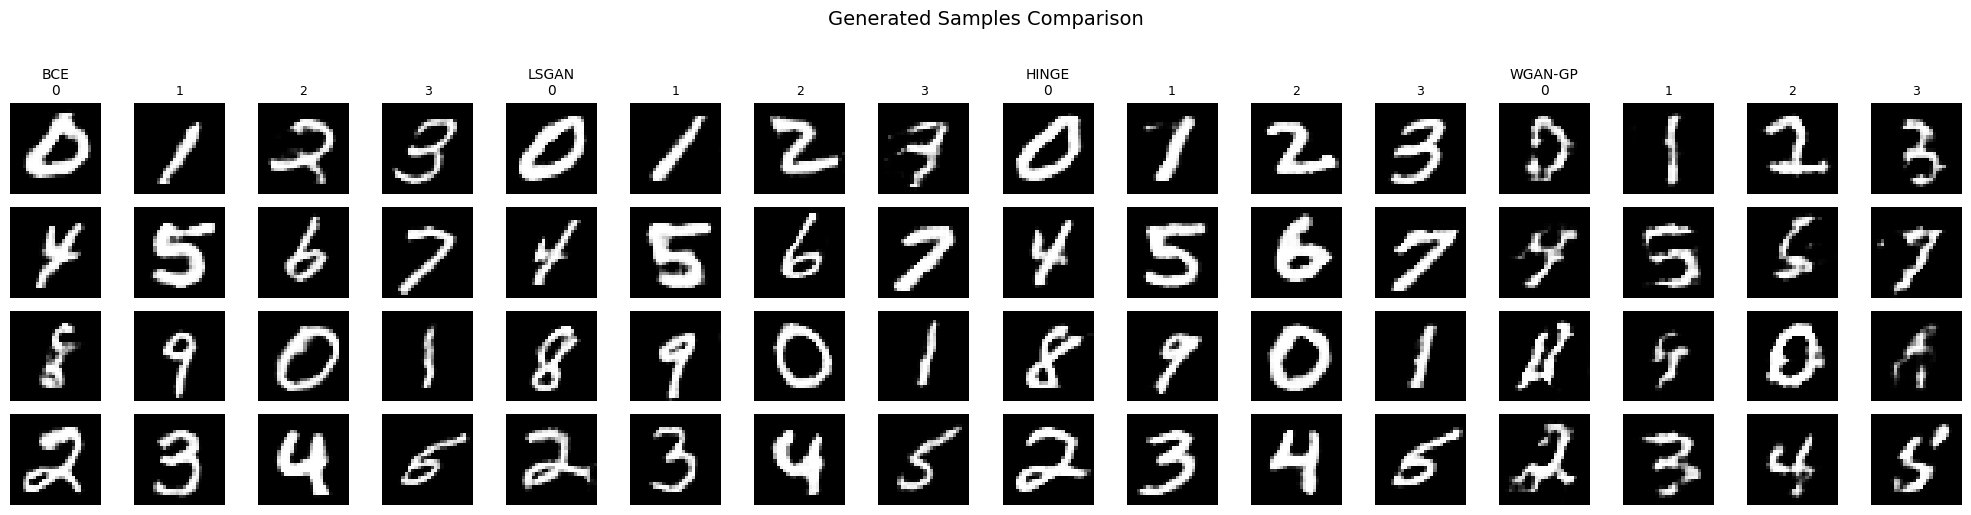

Saved: images/samples_comparison.png


In [16]:
# Generated Samples Comparison Grid

def plot_samples_comparison(results):
    """Show final generated samples from each strategy side by side."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    fig, axes = plt.subplots(4, n_strategies * 4, figsize=(n_strategies * 5, 5))
    
    for col, strategy in enumerate(strategies):
        samples = results[strategy]['final_samples']
        labels = results[strategy]['labels_test']
        
        for i in range(16):
            row = i // 4
            sub_col = i % 4
            ax = axes[row, col * 4 + sub_col]
            
            img = samples[i].numpy().reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Add strategy name as title for first row
            if i == 0:
                ax.set_title(f'{strategy.upper()}\n{labels[i].item()}', fontsize=10)
            elif row == 0:
                ax.set_title(str(labels[i].item()), fontsize=9)
    
    fig.suptitle('Generated Samples Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/samples_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/samples_comparison.png")

plot_samples_comparison(benchmark_results)

**Figure 8.1** - Generated samples from each loss strategy using balanced labels (digits 0-9). Each column group shows 16 samples from a single strategy, with digit labels indicated in the header row.

The grid illustrates representative conditional samples produced by each model after training. BCE and LSGAN generate clear, well-formed digits with consistent class alignment and visible stylistic variation. Hinge loss produces recognizable digits but with slightly reduced smoothness and higher intra-class variability in stroke continuity. In contrast, WGAN-GP exhibits visibly degraded samples, with less stable digit structure and occasional artifacts, reflecting the weaker quantitative performance observed under this training configuration.

In [17]:
# Optional: Export benchmark results to CSV

def export_results_csv(results, filename='benchmark_results.csv'):
    """Export benchmark results to CSV for further analysis."""
    import csv
    
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Strategy', 'FID', 'KID_Mean', 'KID_Std', 'Training_Time_Seconds'])
        
        for name, data in results.items():
            writer.writerow([
                name,
                f"{data['fid']:.4f}",
                f"{data['kid_mean']:.6f}",
                f"{data['kid_std']:.6f}",
                f"{data['training_time']:.2f}"
            ])
    
    print(f"Results exported to {filename}")

# export_results_csv(benchmark_results)

## 8.3 Per-class Grid

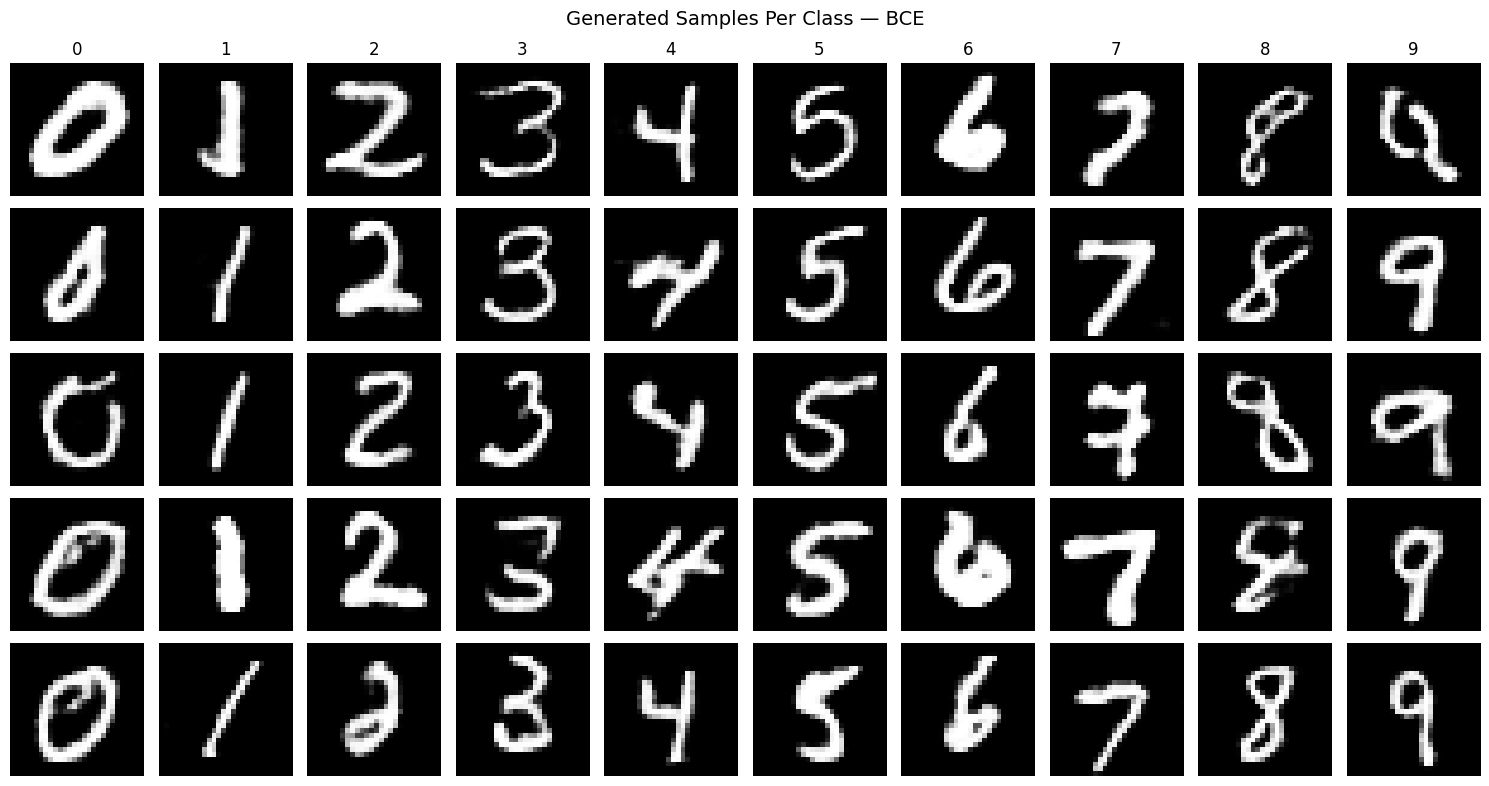

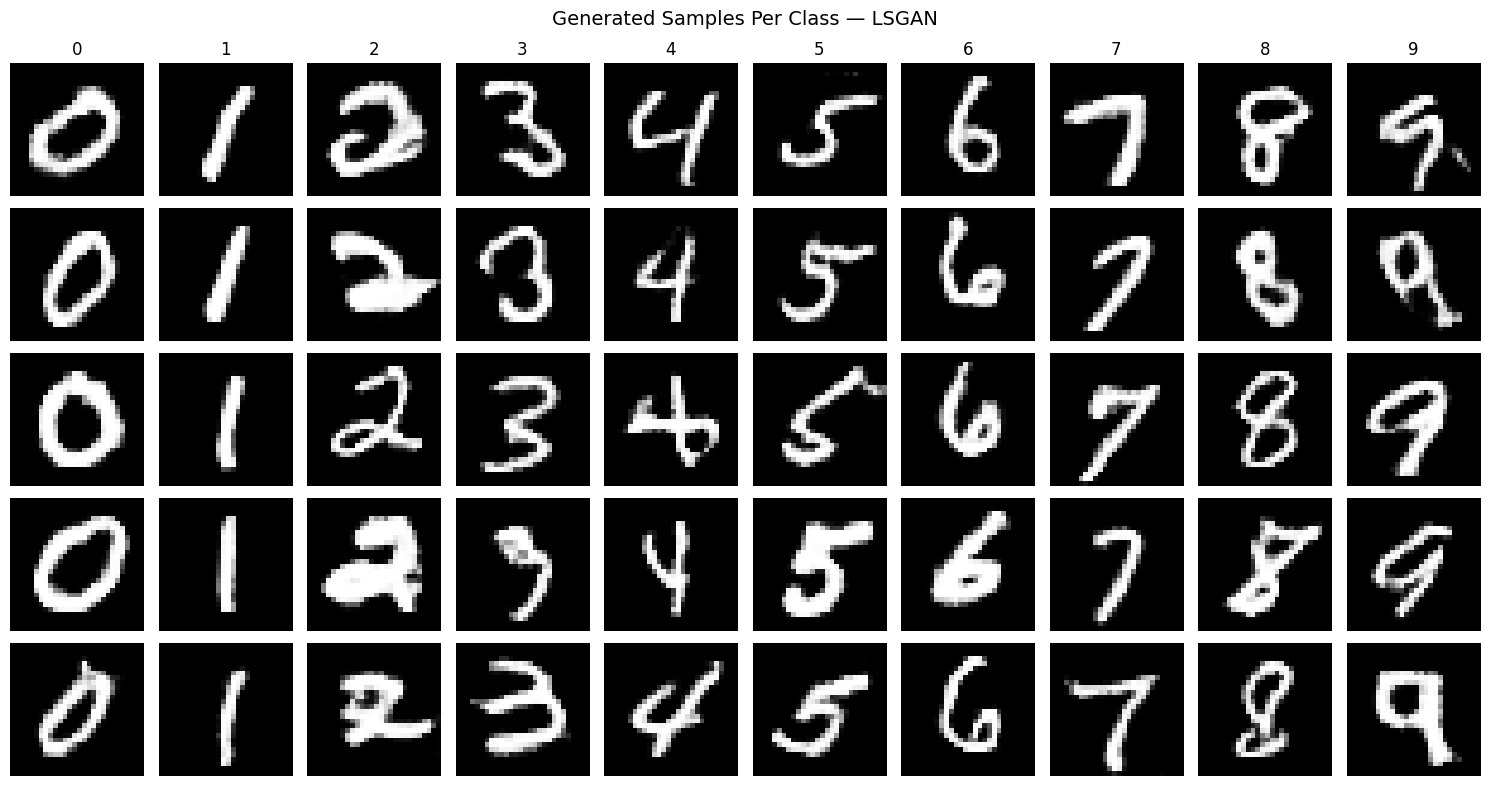

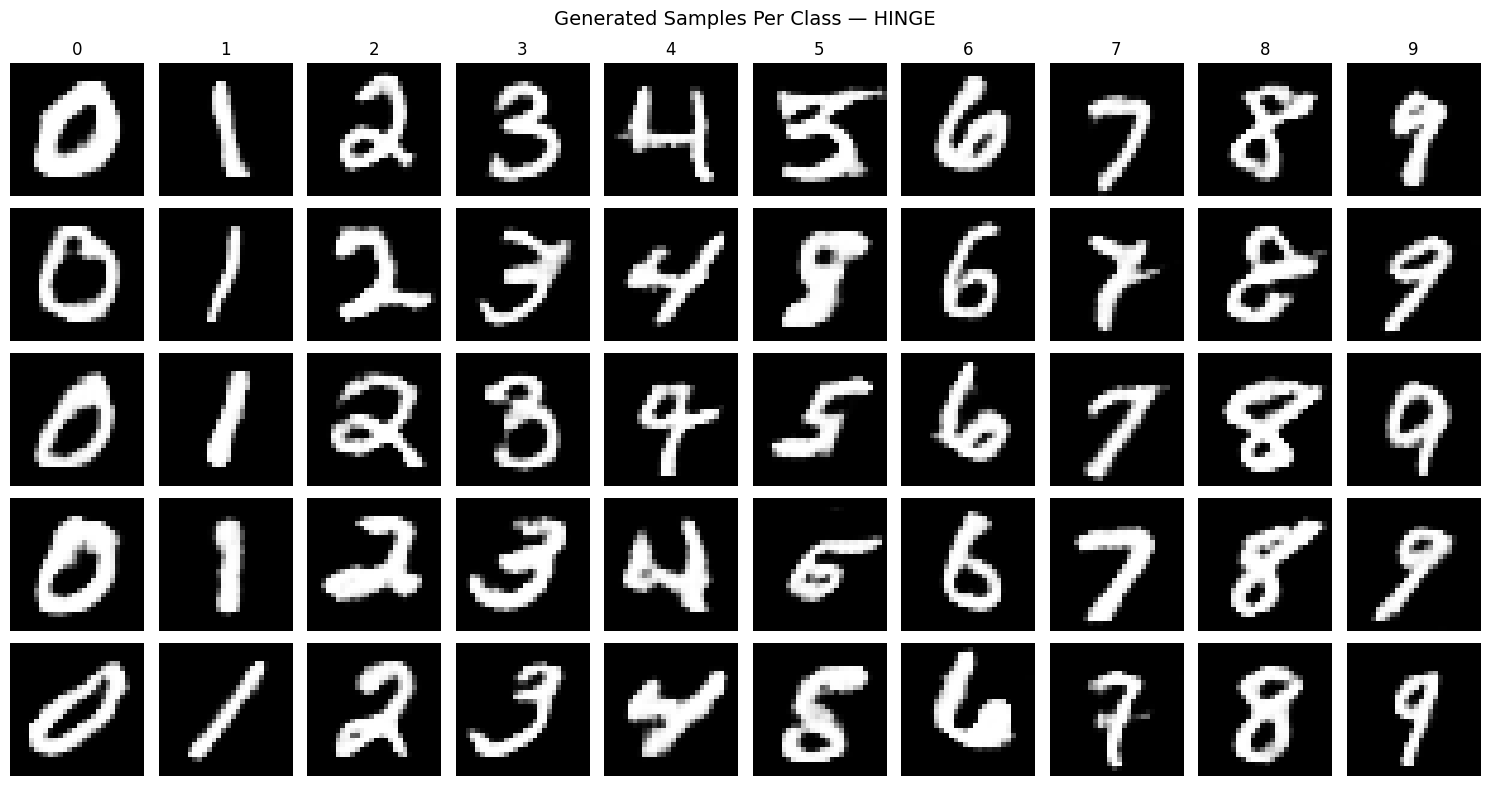

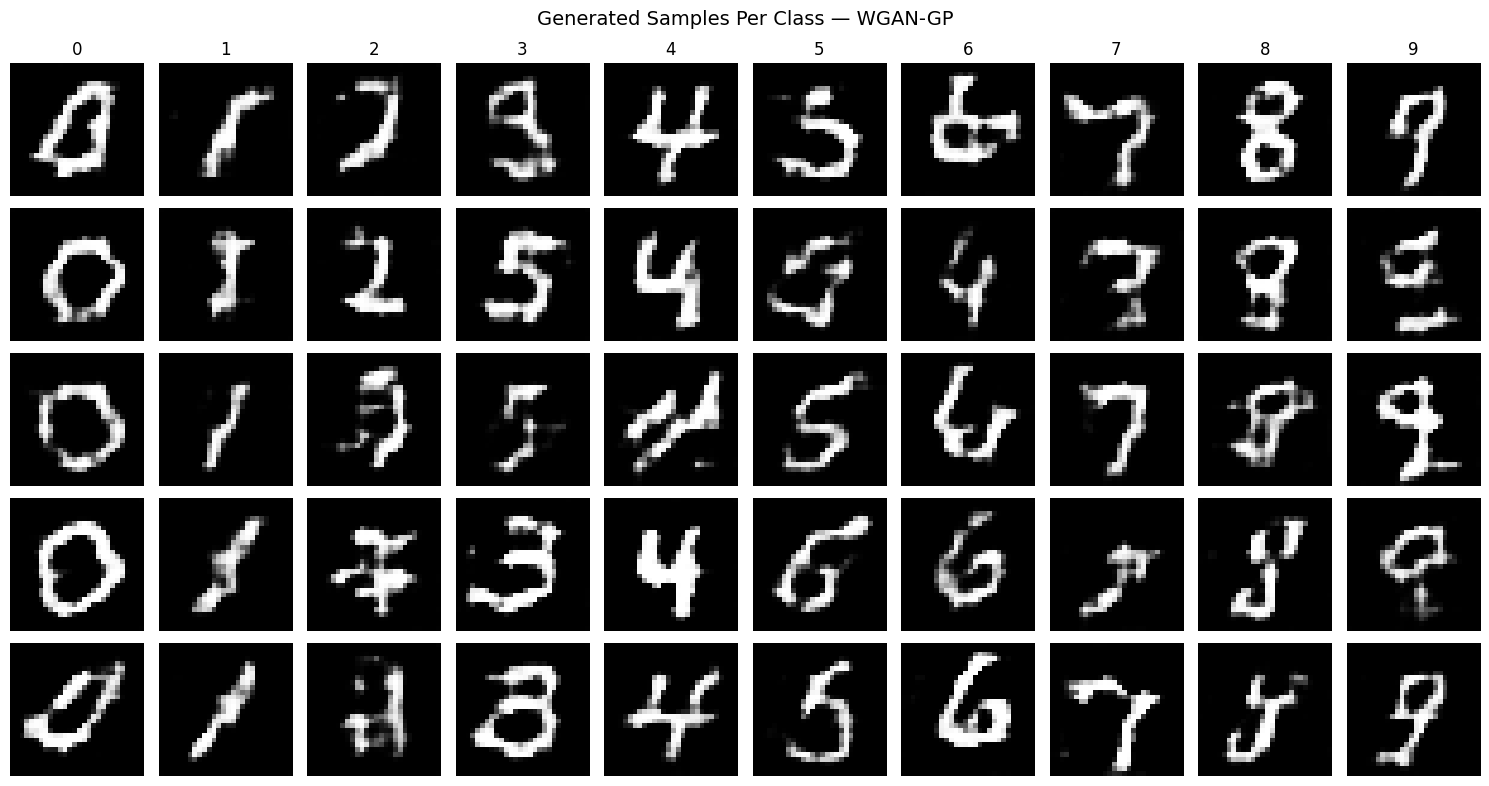

In [18]:
def plot_per_class(g_model, rows_per_class=5, title="Generated Samples Per Class"):
    """Generates a grid with one column per digit class (0-9)."""
    fig, axes = plt.subplots(rows_per_class, 10, figsize=(15, 8))

    for digit in range(10):
        noise = torch.randn(rows_per_class, LATENT_DIM, device=device)
        labels = torch.full((rows_per_class,), digit, device=device).long()  # shape: [B]

        with torch.no_grad():
            images = g_model(noise, labels)

        for row in range(rows_per_class):
            img = images[row].cpu().numpy().reshape(28, 28)
            axes[row, digit].imshow(img, cmap='gray')
            axes[row, digit].axis('off')

            if row == 0:
                axes[row, digit].set_title(str(digit))

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_per_class(g_model, title=f"Generated Samples Per Class — {strategy_name.upper()}")

**Figure 8.2** - Per-class generation grid showing five samples per digit (0-9) with different noise vectors. Each column corresponds to a conditioned class, demonstrating intra-class diversity and label consistency.

## 8.4 Fixed-Z

A key property of conditional GANs is the ability to disentangle the latent noise vector z from the class label y. To verify that our cGAN has learned this separation, we fix a single noise vector and vary the conditioned label across all digits (0-9). If conditioning is correctly learned, the same z should produce digits that share stylistic characteristics (such as stroke thickness, slant, or size) while differing only in their identity. This visualization provides qualitative evidence that the generator uses z to control appearance and y to control semantic content.

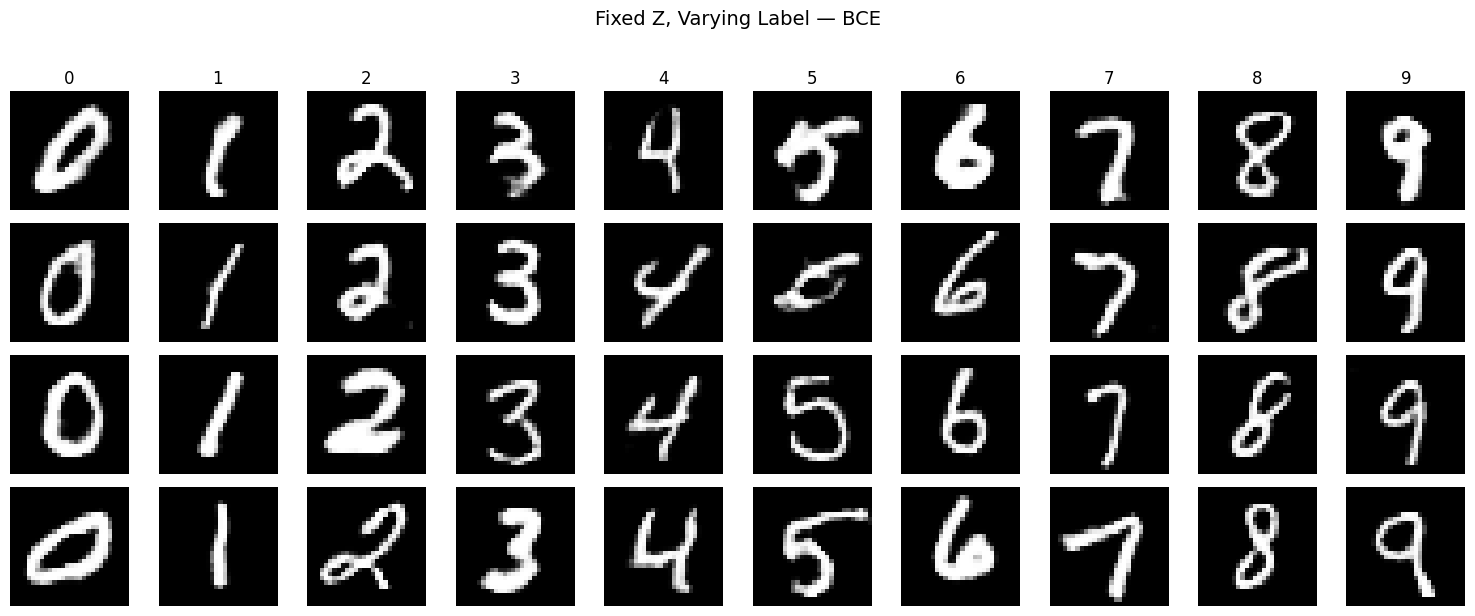

Saved: images/fixed_z_varying_label.png


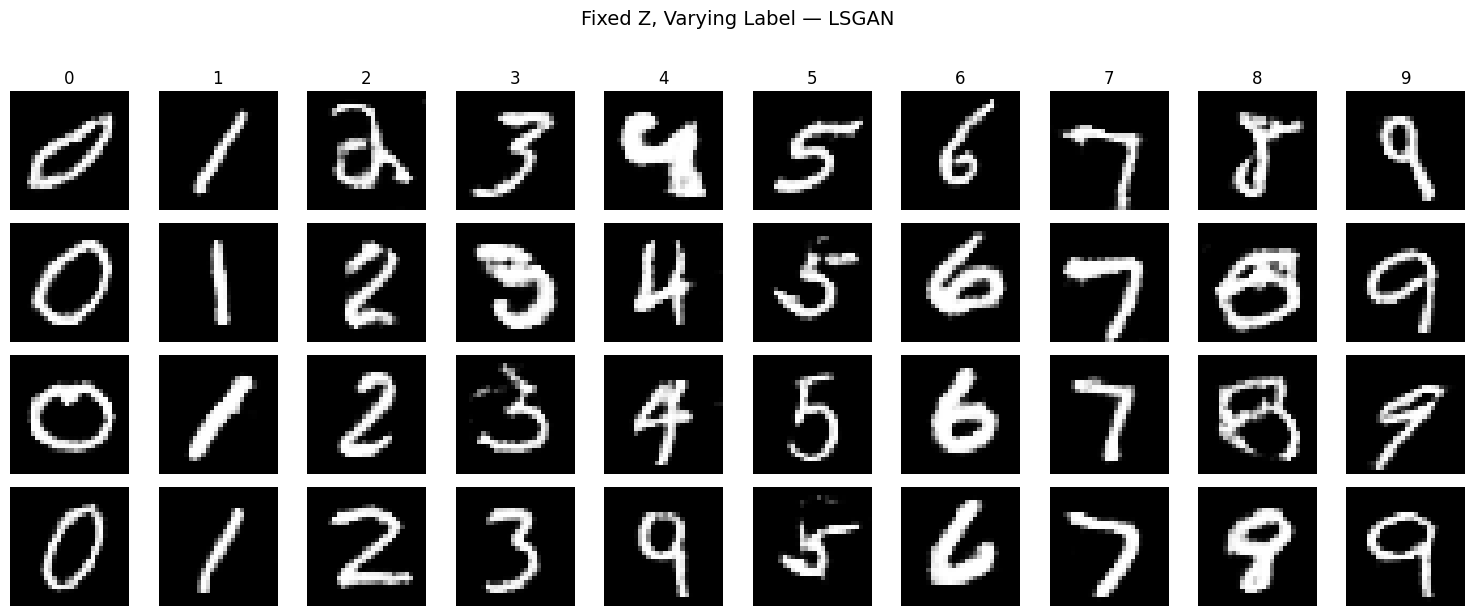

Saved: images/fixed_z_varying_label.png


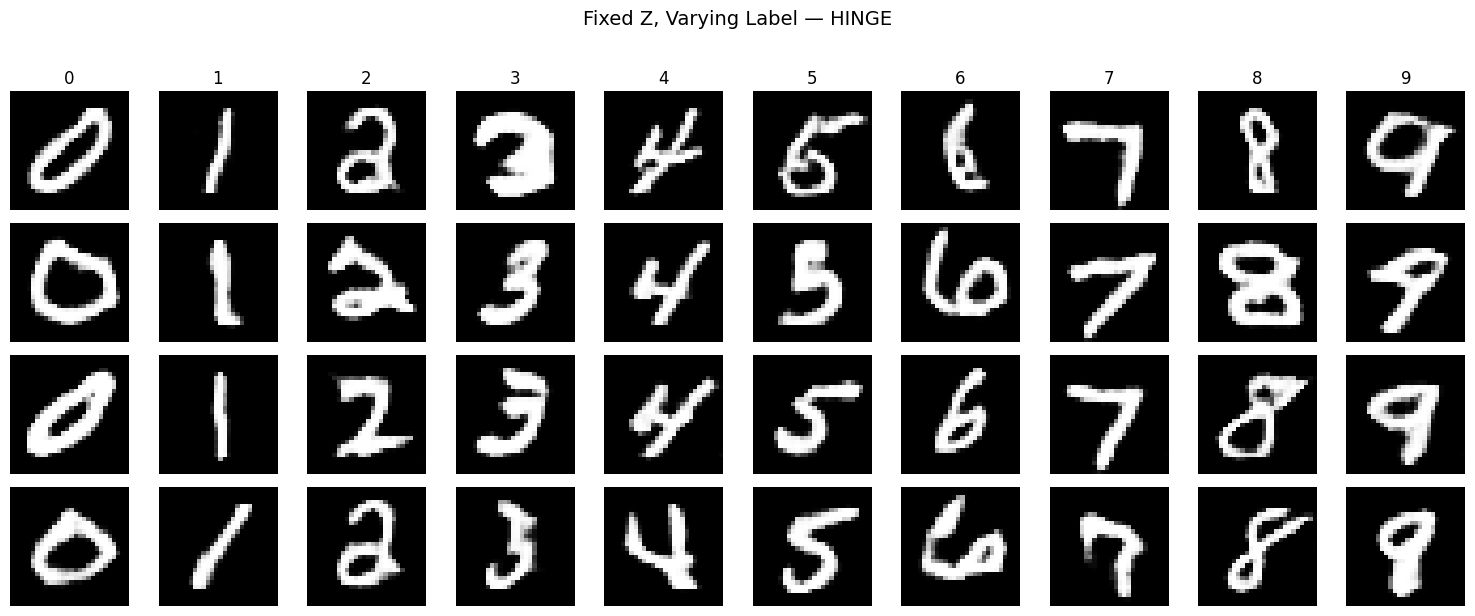

Saved: images/fixed_z_varying_label.png


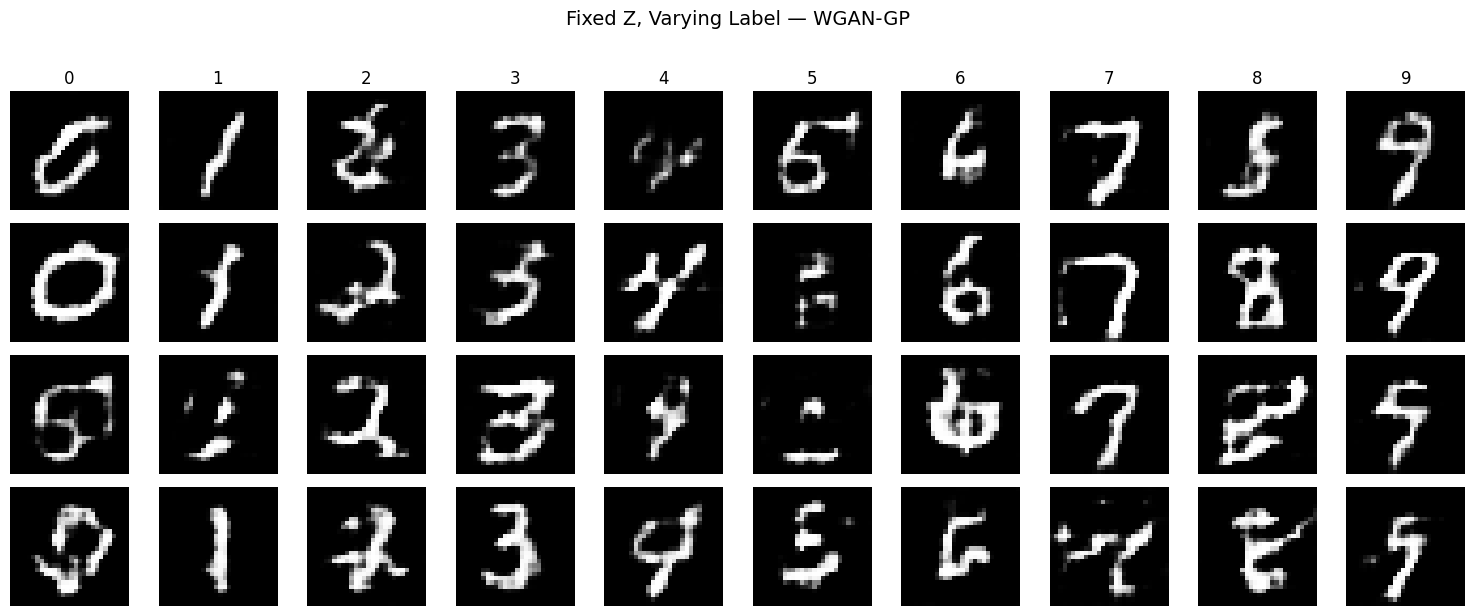

Saved: images/fixed_z_varying_label.png


In [19]:
# =============================================================================
# Fixed Z, Varying Label Visualization
# =============================================================================
# Demonstrates controllability: same noise vector produces different digits
# when conditioned on different labels.

def plot_fixed_z_varying_label(g_model, n_rows=4, title="Fixed Z, Varying Label (0-9)"):
    """
    Generate images using fixed noise vectors but varying labels.
    Each row uses the same z, columns show digits 0-9.
    
    This visually demonstrates that the cGAN has learned to use the label
    to control which digit is generated, independent of the noise vector.
    """
    g_model.eval()
    
    fig, axes = plt.subplots(n_rows, 10, figsize=(15, n_rows * 1.5))
    
    with torch.no_grad():
        for row in range(n_rows):
            # Fix one noise vector for this row
            fixed_z = torch.randn(1, LATENT_DIM, device=device)
            
            for digit in range(10):
                label = torch.tensor([digit], device=device).long()
                
                # Generate with fixed z, varying label
                sample = g_model(fixed_z, label)
                
                img = sample[0].cpu().numpy().reshape(28, 28)
                axes[row, digit].imshow(img, cmap='gray')
                axes[row, digit].axis('off')
                
                # Column headers (digit labels)
                if row == 0:
                    axes[row, digit].set_title(str(digit), fontsize=12)
            
            # Row label
            axes[row, 0].set_ylabel(f'z_{row+1}', fontsize=10, rotation=0, labelpad=20)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/fixed_z_varying_label.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/fixed_z_varying_label.png")


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_fixed_z_varying_label(g_model, n_rows=4, title=f"Fixed Z, Varying Label — {strategy_name.upper()}")

**Figure 8.3** - Controllability demonstration using fixed noise vectors. Each row uses the same z while varying the label from 0 to 9, showing that the generator disentangles style (controlled by z) from digit identity (controlled by label).

# 9. Model Saving

---

In [20]:
def save_models(results):
    """Saves generator and discriminator state dicts for all strategies."""
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    
    for strategy_name, data in results.items():
        g_path = os.path.join(MODEL_OUTPUT_PATH, f'G_{strategy_name}.pt')
        d_path = os.path.join(MODEL_OUTPUT_PATH, f'D_{strategy_name}.pt')
        
        torch.save(data['g_model_state'], g_path)
        torch.save(data['d_model_state'], d_path)
        
        print(f"Saved: {g_path}, {d_path}")

save_models(benchmark_results)

Saved: model/G_bce.pt, model/D_bce.pt
Saved: model/G_lsgan.pt, model/D_lsgan.pt
Saved: model/G_hinge.pt, model/D_hinge.pt
Saved: model/G_wgan-gp.pt, model/D_wgan-gp.pt


# 10. Single-Image Inference

---

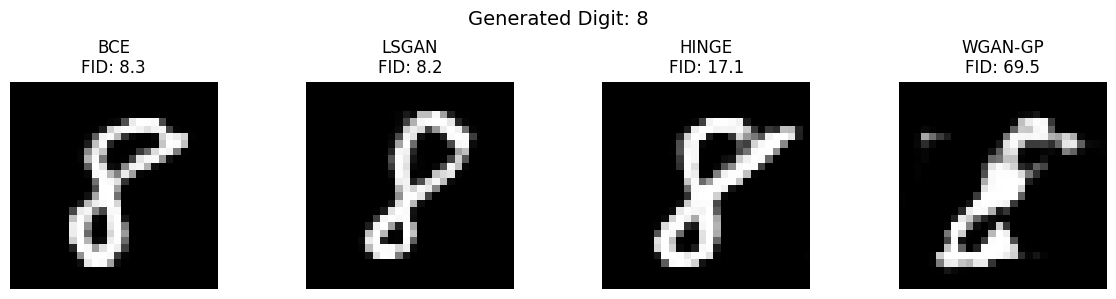

In [22]:
# Specify a digit from 0-9
digit = 8

# Use same noise for fair comparison
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([digit], device=device).long() 

fig, axes = plt.subplots(1, len(benchmark_results), figsize=(3 * len(benchmark_results), 3))

for idx, (strategy_name, data) in enumerate(benchmark_results.items()):
    g_model = Generator().to(device)
    g_model.load_state_dict(data['g_model_state'])
    g_model.eval()
    
    with torch.no_grad():
        generated = g_model(z, label)
    
    img = generated[0].cpu().numpy().reshape(28, 28)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"{strategy_name.upper()}\nFID: {data['fid']:.1f}")
    axes[idx].axis('off')

fig.suptitle(f"Generated Digit: {digit}", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 10.1** - Comparison of digit $8$ generated by each loss strategy using the same noise vector $z$. This demonstrates how different adversarial objectives produce visually distinct outputs from identical latent input.